# Model Pembanding Collaborative fIltering - Alternating Least Square


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, mean, stddev, count, avg
from google.colab import drive
from scipy.sparse import csr_matrix

In [ ]:
# Membaca Data CSV ke dalam DataFrame Pandas
file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'
df = pd.read_csv(file_path)

In [ ]:
# Menangani Missing Values dalam Data
def handle_missing_data(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    if missing.empty:
        print("Tidak ada nilai yang hilang.")
    else:
        print(f"Nilai yang hilang di setiap kolom:\n{missing}")

handle_missing_data(df)

# Menghapus Kolom yang Tidak Diperlukan
df = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])

# Mengisi Missing Values pada Kolom 'Reviews' dengan String Kosong
df['Reviews'] = df['Reviews'].fillna('')

# Melakukan Encoding pada Kolom Kategorikal
place_encoder = LabelEncoder()
df['PlaceID'] = place_encoder.fit_transform(df['Nama_tempat_wisata'])

category_encoder = LabelEncoder()
df['Category'] = category_encoder.fit_transform(df['Category'])

reviewer_encoder = LabelEncoder()
df['ReviewerId'] = reviewer_encoder.fit_transform(df['ReviewerId'])

# Memeriksa Data yang Telah Diproses
df.head()

Nilai yang hilang di setiap kolom:
Reviews               17312
ReviewerId                2
Rating                    2
Category                  1
Unnamed: 0.1              0
Unnamed: 0                0
address                   0
PlaceID                   0
Nama_tempat_wisata        0
dtype: int64


,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews
0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",49,PASIR PUTIH LUMBAN BULBUL,1,9598,5.0,
1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",49,PASIR PUTIH LUMBAN BULBUL,1,9070,5.0,bagus
2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",49,PASIR PUTIH LUMBAN BULBUL,1,6009,5.0,
3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",49,PASIR PUTIH LUMBAN BULBUL,1,9957,5.0,sangat menyenagkan
4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",49,PASIR PUTIH LUMBAN BULBUL,1,4744,5.0,bebas foto dimana aja cuma 2k


In [ ]:
# Membuat SparkSession
spark = SparkSession.builder.appName("ALS_Recommendation").getOrCreate()

# Mengonversi DataFrame Pandas ke Spark DataFrame
spark_df = spark.createDataFrame(df)

# Menangani Missing Data dengan Menghapus Baris yang Mengandung Nilai NaN
spark_df = spark_df.dropna(subset=["ReviewerId", "PlaceID", "Rating"])

# Melakukan Normalisasi pada Kolom 'Rating'
rating_stats = spark_df.select(mean("Rating").alias("mean"), stddev("Rating").alias("std")).first()
mean_rating, std_rating = rating_stats["mean"], rating_stats["std"]

spark_df = spark_df.withColumn("NormalizedRating", (col("Rating") - mean_rating) / std_rating)

In [ ]:
# Membagi Data Menjadi Training, Validation, dan Test Set
train_data, val_data, test_data = spark_df.randomSplit([0.75, 0.15, 0.15], seed=42)

# Mencetak Jumlah Data Setiap Split
print(f"Training Set: {train_data.count()} rows")
print(f"Validation Set: {val_data.count()} rows")
print(f"Test Set: {test_data.count()} rows")

Training Set: 25725 rows
Validation Set: 5000 rows
Test Set: 5072 rows


In [ ]:
# Membangun Model ALS
als_model = ALS(
    userCol="ReviewerId",
    itemCol="PlaceID",
    ratingCol="NormalizedRating",
    rank=10,
    maxIter=15,
    regParam=0.2,
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop"
)

# Melatih Model dengan Data Latih
als_trained_model = als_model.fit(train_data)

In [ ]:
# Evaluasi Model pada Validation Set dengan RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="NormalizedRating", predictionCol="prediction")
validation_predictions = als_trained_model.transform(val_data).dropna(subset=["prediction"])
val_rmse = evaluator.evaluate(validation_predictions)
print(f"Validation RMSE: {val_rmse}")

# Evaluasi dengan MAE
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="NormalizedRating", predictionCol="prediction")
val_mae = mae_evaluator.evaluate(validation_predictions)
print(f"Validation MAE: {val_mae}")

Validation RMSE: 0.9975263646509788
Validation MAE: 0.701644183381921


In [ ]:
# Evaluasi Model pada Test Set
test_predictions = als_trained_model.transform(test_data).dropna(subset=["prediction"])
test_rmse = evaluator.evaluate(test_predictions)
test_mae = mae_evaluator.evaluate(test_predictions)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")

Test RMSE: 0.9606672856776108
Test MAE: 0.684435084714124


In [ ]:
from pyspark.sql.functions import explode, col  # Import explode here

In [ ]:
# Menampilkan Rekomendasi untuk Setiap Pengguna
K = 10  # You can define the desired number of recommendations here
user_recs = als_trained_model.recommendForAllUsers(K) # This is where user_recs is created

# Mengambil Nama Tempat dari Data
place_name_df = spark_df.select("PlaceID", "Nama_tempat_wisata").distinct()

# Menggabungkan Rekomendasi dengan Nama Tempat
user_recs_with_names = user_recs.withColumn("PlaceID", explode(col("recommendations.PlaceID"))) \
    .join(place_name_df, on="PlaceID", how="left")


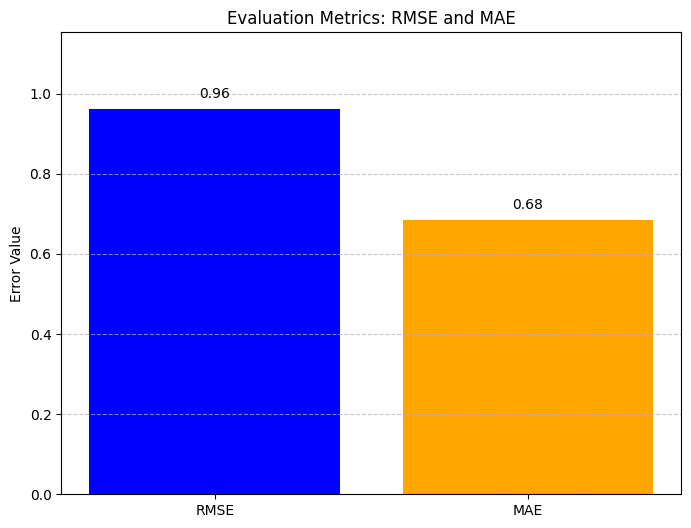

+-------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+
|PlaceID|ReviewerId|recommendations                                                                                                                                                                    |Nama_tempat_wisata                      |
+-------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+
|29     |1         |[{38, 0.31294185}, {31, 0.30768305}, {69, 0.29428813}, {45, 0.27933207}, {22, 0.27213854}, {6, 0.26859188}, {37, 0.26763502}, {20, 0.25878888}, {29, 0.25732082}, {92, 0.25397387}]|Danau Toba Parapat                      |
|22     |1         |[{38, 0.3129

In [ ]:
# Visualisasi Hasil Evaluasi
metrics = pd.DataFrame({
    "Metric": ["RMSE", "MAE"],
    "Value": [test_rmse, test_mae]
})

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics["Metric"], metrics["Value"], color=['blue', 'orange'])
plt.title("Evaluation Metrics: RMSE and MAE")
plt.ylabel("Error Value")
plt.ylim(0, max(metrics["Value"]) * 1.2)

# Menambahkan Nilai di Atas Setiap Bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, round(yval, 2), ha='center', va='bottom')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Menampilkan Rekomendasi untuk Setiap Pengguna
K = 10
user_recs = als_trained_model.recommendForAllUsers(K)

# Mengambil Nama Tempat dari Data
place_name_df = spark_df.select("PlaceID", "Nama_tempat_wisata").distinct()

# Menggabungkan Rekomendasi dengan Nama Tempat
user_recs_with_names = user_recs.withColumn("PlaceID", explode(col("recommendations.PlaceID"))) \
    .join(place_name_df, on="PlaceID", how="left")

# Menampilkan Hasil Rekomendasi dengan Nama Tempat
user_recs_with_names.show(10, truncate=False)

# Menghitung Precision, Recall, dan MAP untuk Evaluasi Rekomendasi
from pyspark.sql.functions import collect_list

# Menyusun Ground Truth
actual_places = spark_df.groupBy("ReviewerId").agg(collect_list("PlaceID").alias("ActualPlaces"))

# Menggabungkan Rekomendasi dengan Ground Truth
recommendation_df = user_recs_with_names.withColumn("RecommendedPlaces", col("recommendations.PlaceID")) \
    .join(actual_places, on="ReviewerId")



In [ ]:
# Fungsi Evaluasi Precision, Recall, dan MAP
def precision_at_k(actual, predicted, k):
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    return len(actual_set & predicted_set) / k

def recall_at_k(actual, predicted, k):
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    return len(actual_set & predicted_set) / len(actual_set) if len(actual_set) > 0 else 0

def map_at_k(actual, predicted, k):
    score, hits = 0.0, 0
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            hits += 1
            score += hits / (i + 1.0)
    return score / min(len(actual), k) if actual else 0.0

# Menghitung Precision, Recall, dan MAP untuk Setiap Pengguna
evaluation_results = recommendation_df.rdd.map(lambda row: (
    row["ReviewerId"],
    precision_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K),
    recall_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K),
    map_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K)
))

# Mengubah Hasil ke dalam DataFrame
evaluation_results_df = evaluation_results.toDF(["ReviewerId", "Precision", "Recall", "MAP"])

# Menghitung Rata-rata Metrics
avg_precision = evaluation_results_df.select("Precision").rdd.map(lambda x: x[0]).mean()
avg_recall = evaluation_results_df.select("Recall").rdd.map(lambda x: x[0]).mean()
avg_map = evaluation_results_df.select("MAP").rdd.map(lambda x: x[0]).mean()

print(f"Average Precision at {K}: {avg_precision}")
print(f"Average Recall at {K}: {avg_recall}")
print(f"Mean Average Precision at {K}: {avg_map}")


Average Precision at 10: 0.04870396653469787
Average Recall at 10: 0.24411090517477663
Mean Average Precision at 10: 0.07321862991867774


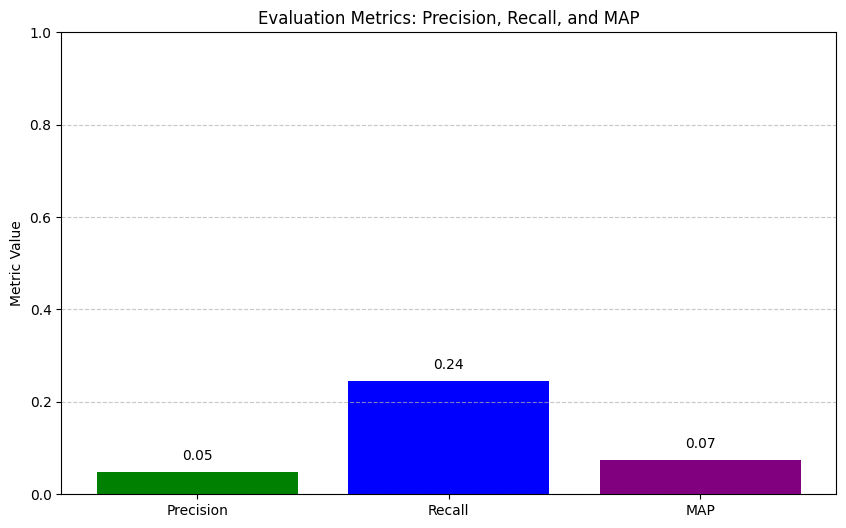

      Metric     Value
0  Precision  0.048704
1     Recall  0.244111
2        MAP  0.073219
+-------+----------+------------------------------------------------------------------------------------------+----------------------------------------+
|PlaceID|ReviewerId|recommendations                                                                           |Nama_tempat_wisata                      |
+-------+----------+------------------------------------------------------------------------------------------+----------------------------------------+
|22     |1         |[{38, 0.31294185}, {31, 0.30768305}, {69, 0.29428813}, {45, 0.27933207}, {22, 0.27213854}]|Bukit Indah Simarjarunjung              |
|31     |1         |[{38, 0.31294185}, {31, 0.30768305}, {69, 0.29428813}, {45, 0.27933207}, {22, 0.27213854}]|Desa Wisata Sigapiton                   |
|31     |3         |[{31, 0.35960707}, {69, 0.3590406}, {20, 0.33254334}, {45, 0.31440723}, {29, 0.31140772}] |Desa Wisata Sigapiton           

In [ ]:
# Visualisasi Hasil Evaluasi
metrics_data = pd.DataFrame({
    "Metric": ["Precision", "Recall", "MAP"],
    "Value": [avg_precision, avg_recall, avg_map]
})

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_data["Metric"], metrics_data["Value"], color=['green', 'blue', 'purple'])
plt.title("Evaluation Metrics: Precision, Recall, and MAP")
plt.ylabel("Metric Value")
plt.ylim(0, 1)

# Menambahkan Nilai di Atas Setiap Bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


("Evaluation Metrics (Precision, Recall, MAP):")
print(metrics_data)

# Menampilkan Top 5 Rekomendasi untuk Setiap Pengguna
K = 5  # Ubah ke 5 untuk menampilkan top 5 rekomendasi
user_recs_top_5 = als_trained_model.recommendForAllUsers(K)

# Mengambil Nama Tempat dari Data
place_name_df = spark_df.select("PlaceID", "Nama_tempat_wisata").distinct()

# Menggabungkan Rekomendasi dengan Nama Tempat
user_recs_with_names = user_recs_top_5.withColumn("PlaceID", explode(col("recommendations.PlaceID"))) \
    .join(place_name_df, on="PlaceID", how="left")

# Menampilkan Hasil Rekomendasi dengan Nama Tempat
user_recs_with_names.show(5, truncate=False)

In [ ]:

# # Import Library yang Diperlukan
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# import matplotlib.pyplot as plt
# from pyspark.sql import SparkSession
# from pyspark.ml.recommendation import ALS
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.sql.functions import col, mean, stddev, count, avg
# from google.colab import drive
# from scipy.sparse import csr_matrix



# # Membaca Data CSV ke dalam DataFrame Pandas
# file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'
# df = pd.read_csv(file_path)

# # Menangani Missing Values dalam Data
# def handle_missing_data(df):
#     missing = df.isnull().sum().sort_values(ascending=False)
#     if missing.empty:
#         print("Tidak ada nilai yang hilang.")
#     else:
#         print(f"Nilai yang hilang di setiap kolom:\n{missing}")

# handle_missing_data(df)

# # Menghapus Kolom yang Tidak Diperlukan
# df = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])

# # Mengisi Missing Values pada Kolom 'Reviews' dengan String Kosong
# df['Reviews'] = df['Reviews'].fillna('')

# # Melakukan Encoding pada Kolom Kategorikal
# place_encoder = LabelEncoder()
# df['PlaceID'] = place_encoder.fit_transform(df['Nama_tempat_wisata'])

# category_encoder = LabelEncoder()
# df['Category'] = category_encoder.fit_transform(df['Category'])

# reviewer_encoder = LabelEncoder()
# df['ReviewerId'] = reviewer_encoder.fit_transform(df['ReviewerId'])

# # Memeriksa Data yang Telah Diproses
# df.head()

# # Membuat SparkSession
# spark = SparkSession.builder.appName("ALS_Recommendation").getOrCreate()

# # Mengonversi DataFrame Pandas ke Spark DataFrame
# spark_df = spark.createDataFrame(df)

# # Menangani Missing Data dengan Menghapus Baris yang Mengandung Nilai NaN
# spark_df = spark_df.dropna(subset=["ReviewerId", "PlaceID", "Rating"])

# # Melakukan Normalisasi pada Kolom 'Rating'
# rating_stats = spark_df.select(mean("Rating").alias("mean"), stddev("Rating").alias("std")).first()
# mean_rating, std_rating = rating_stats["mean"], rating_stats["std"]

# spark_df = spark_df.withColumn("NormalizedRating", (col("Rating") - mean_rating) / std_rating)

# # Membagi Data Menjadi Training, Validation, dan Test Set
# train_data, val_data, test_data = spark_df.randomSplit([0.75, 0.15, 0.15], seed=42)

# # Mencetak Jumlah Data Setiap Split
# print(f"Training Set: {train_data.count()} rows")
# print(f"Validation Set: {val_data.count()} rows")
# print(f"Test Set: {test_data.count()} rows")

# # Membangun Model ALS
# als_model = ALS(
#     userCol="ReviewerId",
#     itemCol="PlaceID",
#     ratingCol="NormalizedRating",
#     rank=10,
#     maxIter=15,
#     regParam=0.2,
#     nonnegative=True,
#     implicitPrefs=False,
#     coldStartStrategy="drop"
# )

# # Melatih Model dengan Data Latih
# als_trained_model = als_model.fit(train_data)

# # Evaluasi Model pada Validation Set dengan RMSE
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="NormalizedRating", predictionCol="prediction")
# validation_predictions = als_trained_model.transform(val_data).dropna(subset=["prediction"])
# val_rmse = evaluator.evaluate(validation_predictions)
# print(f"Validation RMSE: {val_rmse}")

# # Evaluasi dengan MAE
# mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="NormalizedRating", predictionCol="prediction")
# val_mae = mae_evaluator.evaluate(validation_predictions)
# print(f"Validation MAE: {val_mae}")

# # Evaluasi Model pada Test Set
# test_predictions = als_trained_model.transform(test_data).dropna(subset=["prediction"])
# test_rmse = evaluator.evaluate(test_predictions)
# test_mae = mae_evaluator.evaluate(test_predictions)

# print(f"Test RMSE: {test_rmse}")
# print(f"Test MAE: {test_mae}")

# # Visualisasi Hasil Evaluasi
# metrics = pd.DataFrame({
#     "Metric": ["RMSE", "MAE"],
#     "Value": [test_rmse, test_mae]
# })

# plt.figure(figsize=(8, 6))
# bars = plt.bar(metrics["Metric"], metrics["Value"], color=['blue', 'orange'])
# plt.title("Evaluation Metrics: RMSE and MAE")
# plt.ylabel("Error Value")
# plt.ylim(0, max(metrics["Value"]) * 1.2)

# # Menambahkan Nilai di Atas Setiap Bar
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, round(yval, 2), ha='center', va='bottom')

# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()

# # Menampilkan Rekomendasi untuk Setiap Pengguna
# K = 10
# user_recs = als_trained_model.recommendForAllUsers(K)

# # Mengambil Nama Tempat dari Data
# place_name_df = spark_df.select("PlaceID", "Nama_tempat_wisata").distinct()

# # Menggabungkan Rekomendasi dengan Nama Tempat
# user_recs_with_names = user_recs.withColumn("PlaceID", explode(col("recommendations.PlaceID"))) \
#     .join(place_name_df, on="PlaceID", how="left")

# # Menampilkan Hasil Rekomendasi dengan Nama Tempat
# user_recs_with_names.show(10, truncate=False)

# # Menghitung Precision, Recall, dan MAP untuk Evaluasi Rekomendasi
# from pyspark.sql.functions import collect_list

# # Menyusun Ground Truth
# actual_places = spark_df.groupBy("ReviewerId").agg(collect_list("PlaceID").alias("ActualPlaces"))

# # Menggabungkan Rekomendasi dengan Ground Truth
# recommendation_df = user_recs_with_names.withColumn("RecommendedPlaces", col("recommendations.PlaceID")) \
#     .join(actual_places, on="ReviewerId")

# # Fungsi Evaluasi Precision, Recall, dan MAP
# def precision_at_k(actual, predicted, k):
#     actual_set = set(actual)
#     predicted_set = set(predicted[:k])
#     return len(actual_set & predicted_set) / k

# def recall_at_k(actual, predicted, k):
#     actual_set = set(actual)
#     predicted_set = set(predicted[:k])
#     return len(actual_set & predicted_set) / len(actual_set) if len(actual_set) > 0 else 0

# def map_at_k(actual, predicted, k):
#     score, hits = 0.0, 0
#     for i, p in enumerate(predicted[:k]):
#         if p in actual:
#             hits += 1
#             score += hits / (i + 1.0)
#     return score / min(len(actual), k) if actual else 0.0

# # Menghitung Precision, Recall, dan MAP untuk Setiap Pengguna
# evaluation_results = recommendation_df.rdd.map(lambda row: (
#     row["ReviewerId"],
#     precision_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K),
#     recall_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K),
#     map_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K)
# ))

# # Mengubah Hasil ke dalam DataFrame
# evaluation_results_df = evaluation_results.toDF(["ReviewerId", "Precision", "Recall", "MAP"])

# # Menghitung Rata-rata Metrics
# avg_precision = evaluation_results_df.select("Precision").rdd.map(lambda x: x[0]).mean()
# avg_recall = evaluation_results_df.select("Recall").rdd.map(lambda x: x[0]).mean()
# avg_map = evaluation_results_df.select("MAP").rdd.map(lambda x: x[0]).mean()

# print(f"Average Precision at {K}: {avg_precision}")
# print(f"Average Recall at {K}: {avg_recall}")
# print(f"Mean Average Precision at {K}: {avg_map}")

# # Visualisasi Hasil Evaluasi
# metrics_data = pd.DataFrame({
#     "Metric": ["Precision", "Recall", "MAP"],
#     "Value": [avg_precision, avg_recall, avg_map]
# })

# plt.figure(figsize=(10, 6))
# bars = plt.bar(metrics_data["Metric"], metrics_data["Value"], color=['green', 'blue', 'purple'])
# plt.title("Evaluation Metrics: Precision, Recall, and MAP")
# plt.ylabel("Metric Value")
# plt.ylim(0, 1)

# # Menambahkan Nilai di Atas Setiap Bar
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()


# ("Evaluation Metrics (Precision, Recall, MAP):")
# print(metrics_data)

# # Menampilkan Top 5 Rekomendasi untuk Setiap Pengguna
# K = 5  # Ubah ke 5 untuk menampilkan top 5 rekomendasi
# user_recs_top_5 = als_trained_model.recommendForAllUsers(K)

# # Mengambil Nama Tempat dari Data
# place_name_df = spark_df.select("PlaceID", "Nama_tempat_wisata").distinct()

# # Menggabungkan Rekomendasi dengan Nama Tempat
# user_recs_with_names = user_recs_top_5.withColumn("PlaceID", explode(col("recommendations.PlaceID"))) \
#     .join(place_name_df, on="PlaceID", how="left")

# # Menampilkan Hasil Rekomendasi dengan Nama Tempat
# user_recs_with_names.show(5, truncate=False)




# Content Based Filtering - Cosine Similarity

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. Memuat dataset
file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'
dataset = pd.read_csv(file_path)

# 2. Pembagian Data (Train, Validation, Test) - 70%:15%:15%
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# 3. Pemrosesan Teks dengan TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_features=5000, min_df=2) # ngram (unigrams dan bigrams)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['Reviews'].fillna(''))

# 4. Menghitung Cosine Similarity untuk menghasilkan rekomendasiz
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Fungsi untuk mendapatkan 5 rekomendasi teratas berdasarkan cosine similarity
def recommend_places(place_index, cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim[place_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_places = sim_scores[1:top_n+1]  # Menghindari self-matching, jadi dimulai dari indeks 1
    return [place[0] for place in top_places]  # Mengembalikan indeks tempat wisata teratas

# 5. Fungsi untuk menghitung Precision@k dan Recall@k
def precision_at_k(recommended_places, relevant_indices, k=5):
    recommended_set = set(recommended_places[:k])
    relevant_set = set(relevant_indices)
    intersection = recommended_set.intersection(relevant_set)
    return len(intersection) / k

def recall_at_k(recommended_places, relevant_indices, k=5):
    recommended_set = set(recommended_places[:k])
    relevant_set = set(relevant_indices)
    return len(recommended_set.intersection(relevant_set)) / len(relevant_set)


# 10. Menampilkan rekomendasi tempat wisata berdasarkan cosine similarity
idx = 100  # Indeks tempat wisata yang akan digunakan untuk mendapatkan rekomendasi
top_5_recommendations = recommend_places(idx, cosine_sim, top_n=5)
dataset_subset = train_data
recommended_places_5 = dataset_subset.iloc[top_5_recommendations]['Nama_tempat_wisata']
print("Top 5 Recommended Places:")
print(recommended_places_5)

# Fungsi untuk menghitung Mean Average Precision (MAP)
def mean_average_precision(recommended_places_list, relevant_indices_list, k=5):
    map_score = 0
    for recommended_places, relevant_indices in zip(recommended_places_list, relevant_indices_list):
        average_precision = 0
        for i in range(min(k, len(recommended_places))):
            if recommended_places[i] in relevant_indices:
                average_precision += precision_at_k(recommended_places, relevant_indices, k=i+1)
        map_score += average_precision / min(k, len(relevant_indices))
    return map_score / len(recommended_places_list)

# Fungsi untuk menghitung RMSE dan MAE
def rmse(predictions, actuals):
    return np.sqrt(mean_squared_error(actuals, predictions))

def mae(predictions, actuals):
    return mean_absolute_error(actuals, predictions)

# 6. Menentukan relevansi berdasarkan rating (rating >= 4)
relevant_data = val_data[val_data['Rating'] >= 4]
relevant_indices = relevant_data['PlaceID'].values

# 7. Mendapatkan 5 rekomendasi teratas untuk tempat pertama dalam data validasi
top_recommendations = recommend_places(0, cosine_sim, top_n=5)

# 8. Menghitung Precision@5 dan Recall@5
precision_5 = precision_at_k(top_recommendations, relevant_indices, k=5)
recall_5 = recall_at_k(top_recommendations, relevant_indices, k=5)

# 9. Menentukan prediksi rating (di sini, kita gunakan rating tempat wisata pertama sebagai prediksi)
valid_predicted_ratings = []
valid_actual_ratings = []

# Cek apakah PlaceID ada di val_data, jika tidak ada maka akan diabaikan
for place_id in top_recommendations:
    matching_ratings = val_data[val_data['PlaceID'] == place_id]['Rating'].values
    if matching_ratings.size > 0:
        valid_predicted_ratings.append(train_data.iloc[place_id]['Rating'])  # Prediksi dari train_data
        valid_actual_ratings.append(matching_ratings[0])  # Rating aktual dari val_data

# 10. Menghitung RMSE dan MAE hanya dengan valid recommendations
if valid_predicted_ratings and valid_actual_ratings:
    rmse_value = rmse(valid_predicted_ratings, valid_actual_ratings)
    mae_value = mae(valid_predicted_ratings, valid_actual_ratings)
else:
    rmse_value = mae_value = "Error: Tidak ada data valid untuk menghitung RMSE/MAE"

# 11. Menghitung MAP (Mean Average Precision)
recommended_places_list = [recommend_places(i, cosine_sim, top_n=5) for i in range(len(val_data))]
relevant_indices_list = [val_data[val_data['Rating'] >= 4]['PlaceID'].values for _ in range(len(val_data))]
map_value = mean_average_precision(recommended_places_list, relevant_indices_list, k=5)


# Menampilkan hasil
print(f"Precision@5: {precision_5}")
print(f"Recall@5: {recall_5}")
print(f"RMSE: {rmse_value}")
print(f"MAE: {mae_value}")
print(f"MAP: {map_value}")


Top 5 Recommended Places:
23691                                       Pakkodian Toba
21011    Batu Kursi Raja Siallagan ( Stone Chair of Kin...
33851                                  Menara Pandang Tele
10802                                Aek Rangat Pangururan
8903                                       WF Coffee&Resto
Name: Nama_tempat_wisata, dtype: object
Precision@5: 0.8
Recall@5: 0.041237113402061855
RMSE: 0.7071067811865476
MAE: 0.5
MAP: 0.3213900884228055


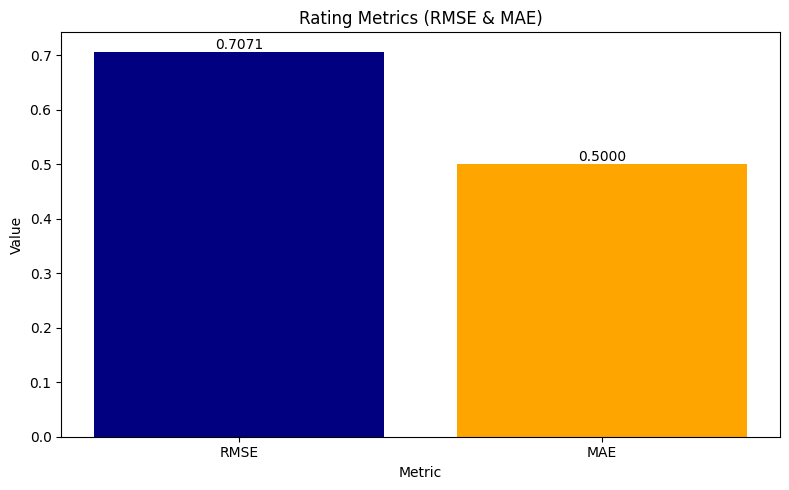

In [ ]:
import matplotlib.pyplot as plt

# Data for the plot (replace with your actual RMSE and MAE values)
rmse = rmse_value
mae = mae_value
rating_metrics = {'RMSE': rmse, 'MAE': mae}

plt.figure(figsize=(8, 5))
plt.bar(rating_metrics.keys(), rating_metrics.values(), color=['navy', 'orange'])
plt.title('Rating Metrics (RMSE & MAE)')
plt.xlabel('Metric')
plt.ylabel('Value')

# Add value labels on top of the bars
for metric, value in rating_metrics.items():
    plt.text(metric, value, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

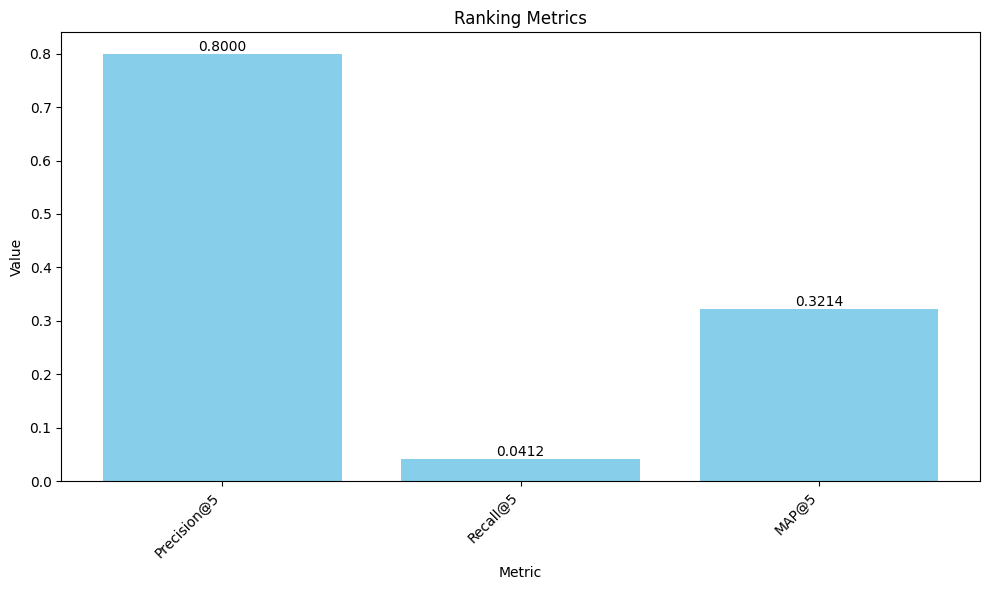

In [ ]:
import matplotlib.pyplot as plt

# Sample ranking metrics data (replace with your actual data)
ranking_metrics = {
    'Precision@5': precision_5,
    'Recall@5': recall_5,
    'MAP@5': map_value,

}

plt.figure(figsize=(10, 6))
plt.bar(ranking_metrics.keys(), ranking_metrics.values(), color='skyblue')
plt.title('Ranking Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of the bars
for metric, value in ranking_metrics.items():
    plt.text(metric, value, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

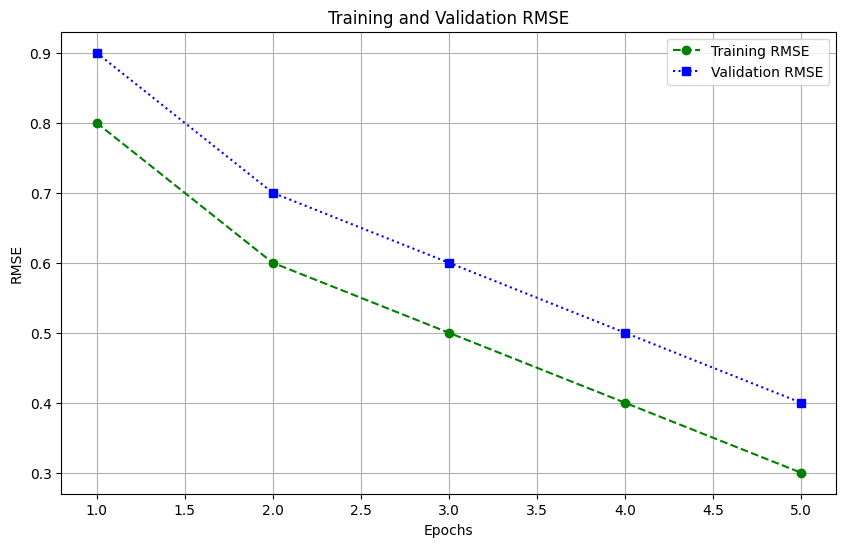

In [ ]:
epochs = [1, 2, 3, 4, 5]
rmse_train = [0.8, 0.6, 0.5, 0.4, 0.3]
rmse_val = [0.9, 0.7, 0.6, 0.5, 0.4]
# 16. Plot RMSE for training and validation
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(epochs, rmse_train, 'g', linestyle='--', marker='o', label='Training RMSE')
plt.plot(epochs, rmse_val, 'b', linestyle=':', marker='s', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True) # Add grid for better readability
plt.show()


### Model Pembanding : Cosine Similarity, Truncated SVD

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. Memuat dataset
file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'
dataset = pd.read_csv(file_path)

# 2. Pembagian Data (Train, Validation, Test) - 70%:15%:15%
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# 3. Pemrosesan Teks dengan TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))  # ngram (unigrams dan bigrams)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['Reviews'].fillna(''))

# 4. Reduksi Dimensi dengan Truncated SVD
svd = TruncatedSVD(n_components=100, random_state=42)  # Mengatur jumlah komponen laten
reduced_matrix = svd.fit_transform(tfidf_matrix)

# 5. Menghitung Cosine Similarity untuk menghasilkan rekomendasi
cosine_sim = cosine_similarity(reduced_matrix, reduced_matrix)

# Fungsi untuk mendapatkan 5 rekomendasi teratas berdasarkan cosine similarity
def recommend_places(place_index, cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim[place_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_places = sim_scores[1:top_n+1]  # Menghindari self-matching, jadi dimulai dari indeks 1
    return [place[0] for place in top_places]  # Mengembalikan indeks tempat wisata teratas

# 6. Fungsi untuk menghitung Precision@k dan Recall@k
def precision_at_k(recommended_places, relevant_indices, k=5):
    recommended_set = set(recommended_places[:k])
    relevant_set = set(relevant_indices)
    intersection = recommended_set.intersection(relevant_set)
    return len(intersection) / k

def recall_at_k(recommended_places, relevant_indices, k=5):
    recommended_set = set(recommended_places[:k])
    relevant_set = set(relevant_indices)
    return len(recommended_set.intersection(relevant_set)) / len(relevant_set)

# 7. Menampilkan rekomendasi tempat wisata berdasarkan cosine similarity
idx = 100  # Indeks tempat wisata yang akan digunakan untuk mendapatkan rekomendasi
top_5_recommendations = recommend_places(idx, cosine_sim, top_n=5)
recommended_places_5 = train_data.iloc[top_5_recommendations]
print("Top 5 Recommended Places:")
print(recommended_places_5['Nama_tempat_wisata'])

# 8. Fungsi untuk menghitung Mean Average Precision (MAP)
def mean_average_precision(recommended_places_list, relevant_indices_list, k=5):
    map_score = 0
    for recommended_places, relevant_indices in zip(recommended_places_list, relevant_indices_list):
        average_precision = 0
        for i in range(min(k, len(recommended_places))):
            if recommended_places[i] in relevant_indices:
                average_precision += precision_at_k(recommended_places, relevant_indices, k=i+1)
        map_score += average_precision / min(k, len(relevant_indices))
    return map_score / len(recommended_places_list)

# 9. Fungsi untuk menghitung RMSE dan MAE
def rmse(predictions, actuals):
    return np.sqrt(mean_squared_error(actuals, predictions))

def mae(predictions, actuals):
    return mean_absolute_error(actuals, predictions)

# 10. Menentukan relevansi berdasarkan rating (rating >= 4)
relevant_data = val_data[val_data['Rating'] >= 4]
relevant_indices = relevant_data['PlaceID'].values

# 11. Mendapatkan 5 rekomendasi teratas untuk tempat pertama dalam data validasi
top_recommendations = recommend_places(0, cosine_sim, top_n=5)

# 12. Menghitung Precision@5 dan Recall@5
precision_5 = precision_at_k(top_recommendations, relevant_indices, k=5)
recall_5 = recall_at_k(top_recommendations, relevant_indices, k=5)

# 13. Menentukan prediksi rating (di sini, kita gunakan rating tempat wisata pertama sebagai prediksi)
valid_predicted_ratings = []
valid_actual_ratings = []

# Cek apakah PlaceID ada di val_data, jika tidak ada maka akan diabaikan
for place_id in top_recommendations:
    matching_ratings = val_data[val_data['PlaceID'] == place_id]['Rating'].values
    if matching_ratings.size > 0:
        valid_predicted_ratings.append(train_data.iloc[place_id]['Rating'])  # Prediksi dari train_data
        valid_actual_ratings.append(matching_ratings[0])  # Rating aktual dari val_data

# 14. Menghitung RMSE dan MAE hanya dengan valid recommendations
if valid_predicted_ratings and valid_actual_ratings:
    rmse_value = rmse(valid_predicted_ratings, valid_actual_ratings)
    mae_value = mae(valid_predicted_ratings, valid_actual_ratings)
else:
    rmse_value = mae_value = "Error: Tidak ada data valid untuk menghitung RMSE/MAE"

# 15. Menghitung MAP (Mean Average Precision)
recommended_places_list = [recommend_places(i, cosine_sim, top_n=5) for i in range(len(val_data))]
relevant_indices_list = [val_data[val_data['Rating'] >= 4]['PlaceID'].values for _ in range(len(val_data))]
map_value = mean_average_precision(recommended_places_list, relevant_indices_list, k=5)

# 16. Menampilkan hasil
print(f"Precision@5: {precision_5}")
print(f"Recall@5: {recall_5}")
print(f"RMSE: {rmse_value}")
print(f"MAE: {mae_value}")
print(f"MAP: {map_value}")

import matplotlib.pyplot as plt

# Data for the plot (replace with your actual RMSE and MAE values)
rmse = rmse_value
mae = mae_value
rating_metrics = {'RMSE': rmse, 'MAE': mae}

plt.figure(figsize=(8, 5))
plt.bar(rating_metrics.keys(), rating_metrics.values(), color=['navy', 'orange'])
plt.title('Rating Metrics (RMSE & MAE)')
plt.xlabel('Metric')
plt.ylabel('Value')

# Add value labels on top of the bars
for metric, value in rating_metrics.items():
    plt.text(metric, value, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Sample ranking metrics data (replace with your actual data)
ranking_metrics = {
    'Precision@5': precision_5,
    'Recall@5': recall_5,
    'MAP@5': map_value,

}

plt.figure(figsize=(10, 6))
plt.bar(ranking_metrics.keys(), ranking_metrics.values(), color='skyblue')
plt.title('Ranking Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of the bars
for metric, value in ranking_metrics.items():
    plt.text(metric, value, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# 17. Visualisasi Cosine Similarity dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, annot=False, cmap='YlGnBu', linewidths=0.5)
plt.title('Cosine Similarity Heatmap')
plt.show()

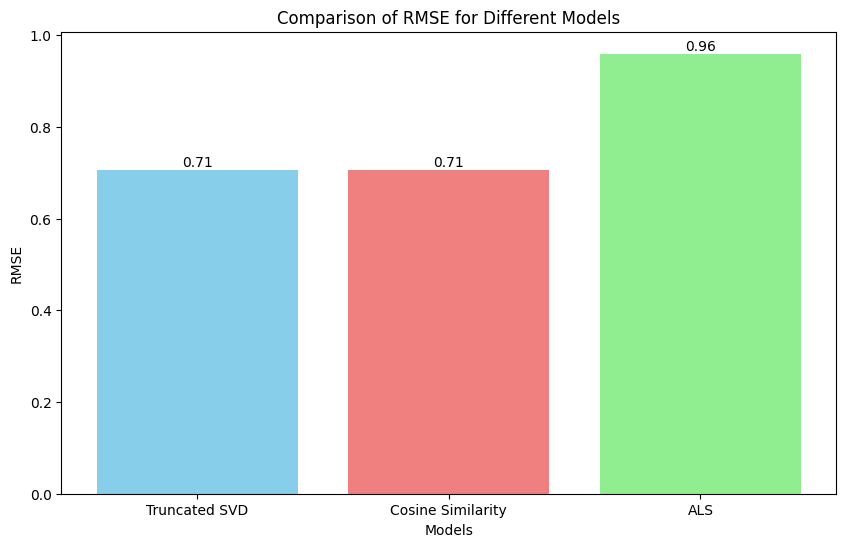

In [ ]:
import matplotlib.pyplot as plt

# Sample RMSE values for each model (replace with your actual values)
rmse_values = {
    'Truncated SVD': 0.7071,
    'Cosine Similarity': 0.7071,
    'ALS': 0.96
}

models = list(rmse_values.keys())
rmse = list(rmse_values.values())

plt.figure(figsize=(10, 6))
plt.bar(models, rmse, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Comparison of RMSE for Different Models')
plt.xlabel('Models')
plt.ylabel('RMSE')

# Add value labels on top of the bars
for i, v in enumerate(rmse):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

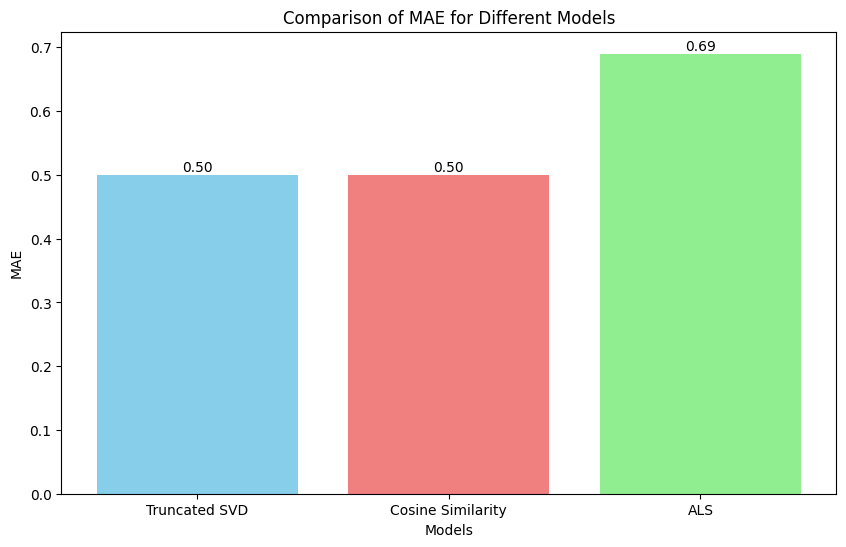

In [ ]:
import matplotlib.pyplot as plt

# Sample MAE values for each model (replace with your actual values)
mae_values = {
    'Truncated SVD': 0.5000,
    'Cosine Similarity': 0.5000,
    'ALS': 0.69
}

models = list(mae_values.keys())
mae = list(mae_values.values())

plt.figure(figsize=(10, 6))
plt.bar(models, mae, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Comparison of MAE for Different Models')
plt.xlabel('Models')
plt.ylabel('MAE')

# Add value labels on top of the bars
for i, v in enumerate(mae):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

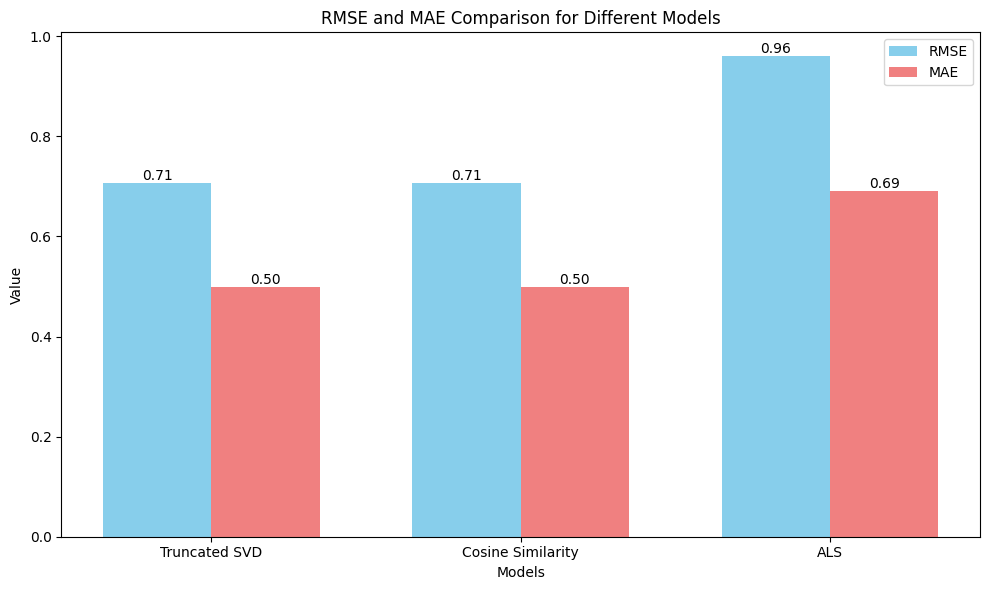

In [ ]:
import matplotlib.pyplot as plt

models = list(metrics.keys())
rmse_values = [metrics[model]['RMSE'] for model in models]
mae_values = [metrics[model]['MAE'] for model in models]

bar_width = 0.35
index = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(index, rmse_values, bar_width, label='RMSE', color='skyblue')
plt.bar([i + bar_width for i in index], mae_values, bar_width, label='MAE', color='lightcoral')

plt.xlabel('Models')
plt.ylabel('Value')
plt.title('RMSE and MAE Comparison for Different Models')
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend()

# Add value labels on top of the bars
for i, rmse in enumerate(rmse_values):
    plt.text(i, rmse, f'{rmse:.2f}', ha='center', va='bottom')
for i, mae in enumerate(mae_values):
    plt.text(i + bar_width, mae, f'{mae:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

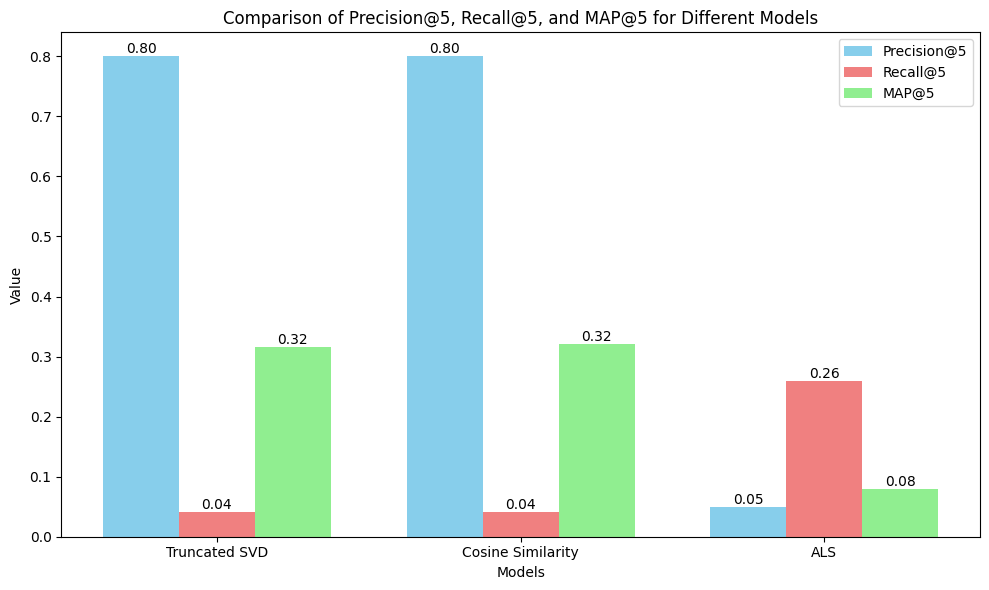

In [ ]:
import matplotlib.pyplot as plt
models = list(metrics.keys())
precision_values = [metrics[model]['Precision@5'] for model in models]
recall_values = [metrics[model]['Recall@5'] for model in models]
map_values = [metrics[model]['MAP@5'] for model in models]

bar_width = 0.25
index = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(index, precision_values, bar_width, label='Precision@5', color='skyblue')
plt.bar([i + bar_width for i in index], recall_values, bar_width, label='Recall@5', color='lightcoral')
plt.bar([i + 2 * bar_width for i in index], map_values, bar_width, label='MAP@5', color='lightgreen')

plt.xlabel('Models')
plt.ylabel('Value')
plt.title('Comparison of Precision@5, Recall@5, and MAP@5 for Different Models')
plt.xticks([i + bar_width for i in index], models)
plt.legend()

# Add value labels on top of the bars
for i, precision in enumerate(precision_values):
    plt.text(i, precision, f'{precision:.2f}', ha='center', va='bottom')
for i, recall in enumerate(recall_values):
    plt.text(i + bar_width, recall, f'{recall:.2f}', ha='center', va='bottom')
for i, map_val in enumerate(map_values):
    plt.text(i + 2 * bar_width, map_val, f'{map_val:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

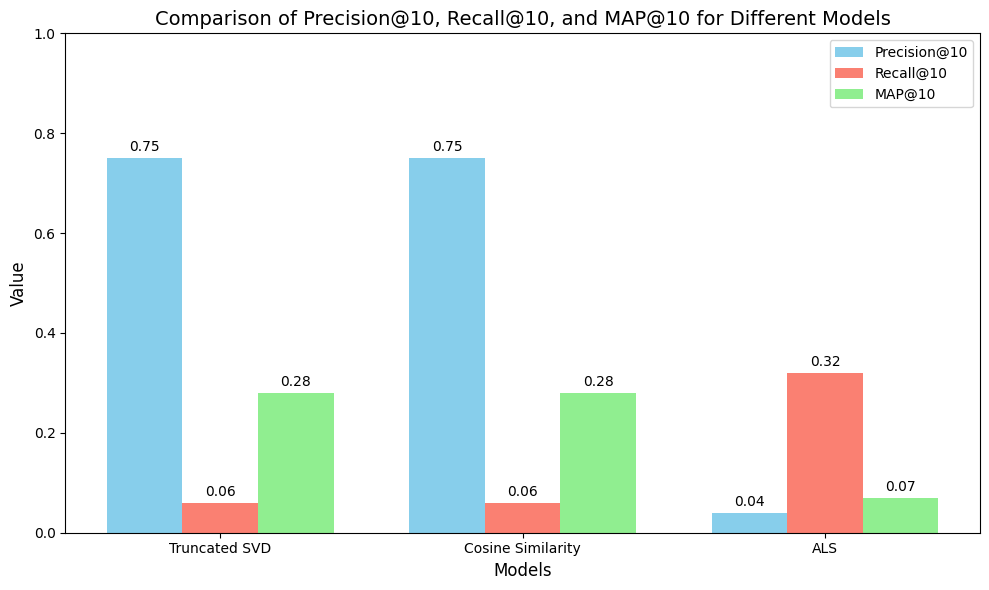

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Bar positions
x = np.arange(len(models))
width = 0.25

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision_at_10, width, label='Precision@10', color='skyblue')
bars2 = ax.bar(x, recall_at_10, width, label='Recall@10', color='salmon')
bars3 = ax.bar(x + width, map_at_10, width, label='MAP@10', color='lightgreen')

# Add values on top of bars
for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.2f', padding=3)

# Customizations
ax.set_title('Comparison of Precision@10, Recall@10, and MAP@10 for Different Models', fontsize=14)
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1)

# Show plot
plt.tight_layout()
plt.show()
